In [1]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from pptx.util import Pt

current_directory = os.getcwd()
# Read the JSON file containing the Session Directory
with open(current_directory+'\\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)
    
# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.drop(columns=['seconds'],inplace=True)
df_mocap.sort_values(by=['epoch_time'])

# applying savgol filter to mocap data 
df_mocap = pd.DataFrame(savgol_filter(df_mocap, 51, 3, axis=0),
                                columns=df_mocap.columns,
                                index=df_mocap.index)

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe_filtered.csv')

df_mpipe.sort_values(by=['epoch_time'])

# drop repeating rows in mpipe
df_mpipe = df_mpipe.drop_duplicates(subset=df_mpipe.columns[0])

# Define the desired column order
column_order = df_mpipe.columns.tolist()

# Reindex the DataFrame with the desired column order
df_mocap = df_mocap.reindex(columns=column_order)

# Creating a presentation to save the graphs in
prs=Presentation()

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

from scipy.interpolate import interp1d

df2=df_mocap.copy()

# Extract the x values from df_mpipe and df2
x = df_mpipe['epoch_time']
x_new = df2['epoch_time']

# Loop through the columns of df2 (excluding epoch_time)
for column in df2.columns[1:]:
    if column in ['TR_x','TR_y','TR_z','LS_x','LS_y','LS_z','RS_x','RS_y','RS_z']:
        k='zero'
    else:
        k='slinear'
    # Extract the y values from df_mpipe for the current column
    y = df_mpipe[column]
    
    # Generate the interpolating function
    interpolating = interp1d(x,y,kind = k,fill_value='extrapolate')
    
    # Interpolate y values onto df2 for the current column
    interpolated_values = interpolating(x_new)
    
    # Add the interpolated values as a new column in df2
    df2['interpolated_' + column] = interpolated_values

df2.drop(df_mocap.columns,axis=1,inplace=True)

# Loop through the columns of the DataFrame
for column in df2.columns:
    # Remove the desired string from column names using str.replace()
    new_column_name = column.replace('interpolated_', '')

    # Rename the column with the updated name
    df2.rename(columns={column: new_column_name}, inplace=True)

df_filtered = df2.copy()

for i in df_filtered.columns.tolist():
    df_filtered[i]=savgol_filter(df_filtered[i],75, 3)

df_filtered.insert(0, 'epoch_time', df_mocap['epoch_time'])

df_mpipe = df_filtered.copy()

corr_list=[]

In [2]:
id = pth.split('\\')[-1].split('_')[-1]

directory_path = pth+'\\graphs_'+id

import shutil
try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' and its contents removed successfully.")
except Exception as e:
    print(f"Error removing directory '{directory_path}': {e}")

os.makedirs(directory_path)

Directory 'E:\arpan_recs\arpan_15-07_fma1\graphs_fma1' and its contents removed successfully.


In [3]:
def rmse_between_dataframes(df1, df2):
    """
    Calculate the Root Mean Squared Error (RMSE) between two DataFrames for each column.

    Parameters:
        df1 (DataFrame): First DataFrame.
        df2 (DataFrame): Second DataFrame.

    Returns:
        Series: RMSE values for each column.

    Examples:
        >>> df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
        >>> df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [3, 5, 7]})
        >>> rmse = rmse_between_dataframes(df1, df2)
        >>> print(rmse)
        A    1.000000
        B    1.000000
        dtype: float64
    """

    # Calculate squared differences between the two DataFrames
    squared_diff = (df1 - df2) ** 2
    diff=df1 - df2

    # Calculate the mean squared difference for each column
    mse = squared_diff.mean()

    # Calculate the RMSE for each column
    rmse = np.sqrt(mse)
    me=np.max(diff)

    return rmse
# print(rmse_between_dataframes(df_mocap,df_mpipe))

average_error = 0
for i in rmse_between_dataframes(df_mocap,df_mpipe):
    average_error+=i
average_error=average_error/len(rmse_between_dataframes(df_mocap,df_mpipe))

print(average_error)

0.05780465456163673


In [4]:
# check for tasks
task_present=False
try:
    # Read the JSON file and retrieve the dictionary
    filename = pth+"\\task_markers.json"
    with open(filename, 'r') as file:
        task_markers = json.load(file)
        task_no=len(task_markers)
        
    tasks=[]
    task_marker=0

    for i in df_mocap['epoch_time'].tolist():
        tasks.append(task_marker)
        if i-df_mocap['epoch_time'].tolist()[0] > task_markers['task'+str(task_marker)] and task_marker<task_no-1:
            task_marker+=1

    task_index=[]
    for i in range(1,task_no):
        index = tasks.index(i)
        task_index.append(index)

    tasks=pd.Series(tasks)

    df_mocap['task']=tasks
    df_mpipe['task']=tasks


    df_mocap.to_csv(pth+"\\mocap_tasks.csv")
    df_mpipe.to_csv(pth+"\\mpipe_tasks.csv")
    task_present=True
    print('task markers present')
except:
    print('no task markers')

task markers present


In [5]:
def pvt(y,t,name):
    # y=np.array(y)
    # slope_mask = np.array(high_slope_index(y,window_length=50,slope_threshold=1.5))
    # if True in slope_mask:
    #     print('wow')
    # y[slope_mask] = np.mean(y)
    plt.plot(t,y,label=name)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.xticks(np.arange(0, max(t)+20, 20))
    plt.legend()
    plt.grid()
    plt.ylim(-180,180)
    if task_present:
        c=1
        for lines in task_markers.values():
            plt.vlines(x=lines, ymin=-180, ymax=180, colors='r', linestyles='dashed',linewidth=0.5,label = "__nolegend__")
            c+=1
    plt.legend()

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(0.5)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.25), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

def add_table_slide(presentation, title, table_data):
    # Add a slide with a title
    slide_layout = presentation.slide_layouts[1]  # Index 1 represents the title and content slide layout
    slide = presentation.slides.add_slide(slide_layout)
    title_placeholder = slide.shapes.title
    title_placeholder.text = title
    
    # Determine table dimensions
    num_rows = len(table_data)   
    num_cols = len(table_data[0])

    # Calculate table width and cell width
    slide_width = presentation.slide_width
    table_width = Inches(9.0)  # Modify this value according to your desired table width
    cell_width = table_width / num_cols

    # Calculate table height and cell height
    slide_height = presentation.slide_height
    table_height = slide_height - Inches(3)  # Modify this value to adjust table height
    cell_height = table_height / num_rows

    # Add a table to the slide
    left = (slide_width - table_width) / 2
    top = (slide_height - table_height) / 2
    table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

    # Set cell content and formatting
    for i, row in enumerate(table_data):
        for j, cell_value in enumerate(row):
            cell = table.cell(i, j)
            cell.text = str(cell_value)
            cell.width = cell_width
            cell.height = cell_height

    return presentation

def high_slope_index(input_list, window_length=200, slope_threshold=0.005):
    output_list = []
    n=window_length
    for i in range(len(input_list)):
        start_idx = max(i - n, 0)
        end_idx = min(i + n + 1, len(input_list))
        surrounding = input_list[start_idx:end_idx]
        slope=np.polyfit(range(len(surrounding)),surrounding,1)[0]
        if abs(slope)>slope_threshold:
            output_list.append(True)
        else:
            output_list.append(False) 
    return output_list

In [6]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []
mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

tasks_data=[]
# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].to_numpy())):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LW_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

Correlation coefficient: 0.7630623516782893


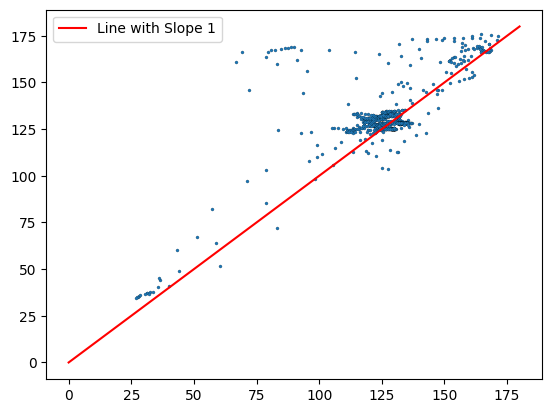

Correlation coefficient:0.7631
RMSE of Right Elbow Angle:13.8102 
Max error :98.3569  epoch_time :86.83


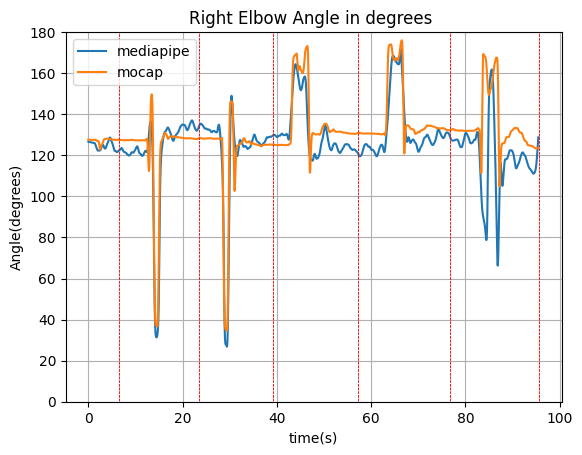

Correlation coefficient: 0.7409773198500307
Correlation coefficient:0.7410
RMSE of Left Elbow Angle:13.9444 
Max error :83.7315  at epoch_time :89.45


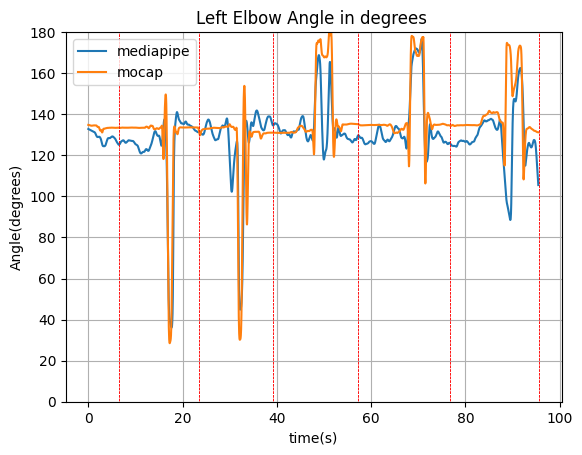

<Figure size 640x480 with 0 Axes>

In [7]:
# graph right elbow angle 

interval=10

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRightElbowAngle, mocapRightElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#plotting scatter
plt.scatter(mpipeRightElbowAngle[0:-1:interval], mocapRightElbowAngle[0:-1:interval], s=5,marker='o',edgecolors='black',linewidth=0.1)
# Plot the line
plt.plot(np.linspace(0, 180, 100), np.linspace(0, 180, 100), label='Line with Slope 1', color='red')
plt.legend()
plt.show()

pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRightElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap')
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapRightElbowAngle,mpipeRightElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Right Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\Right Elbow Angle.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLeftElbowAngle, mocapLeftElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap')
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapLeftElbowAngle,mpipeLeftElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Left Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\Left Elbow Angle.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

In [8]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        print('error in shoulder_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)
        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])

        try:
            v1,v2=basis[0],basis[1]

        except:
            print('error in tr_frame')
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        print('error in tr_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (abs(w) > 1.0e-13).any():
            basis.append(w/np.linalg.norm(w))
        else:   
            print('zero vector detected')
        if np.linalg.norm(w/np.linalg.norm(w)) > 1.001 or np.linalg.norm(w/np.linalg.norm(w)) < 0.999:
            print(np.linalg.norm(w/np.linalg.norm(w))) 
        
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        print('error in roation matrix calculation')
        print(frame1,frame2)
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [9]:
# callibrating shoulders and trunk

# setting the calibration to 2 seconds in the video
mpipe_cf = 200
mocap_cf = 200
RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [10]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe


    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(RSC_mpipe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(LSC_mpipe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)

    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(RSC_mocap,mocapRSF)
    mocapLS_rotmat=rotation_matrix(LSC_mocap,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    if mocapRightElbowAngle[i] < eath:
        mocapRSIE.append(RSeuler[2])
    else:
        mocapRSIE.append(np.nan)

    mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    if mocapLeftElbowAngle[i] < eath:
        mocapLSIE.append(LSeuler[2])
    else:
        mocapLSIE.append(np.nan)
    
    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

Correlation coefficient: 0.453863329757386
Correlation coefficient:0.4539
RMSE of trunk forward/backward: 5.0938 
Max error :15.6660  epoch_time :84.09


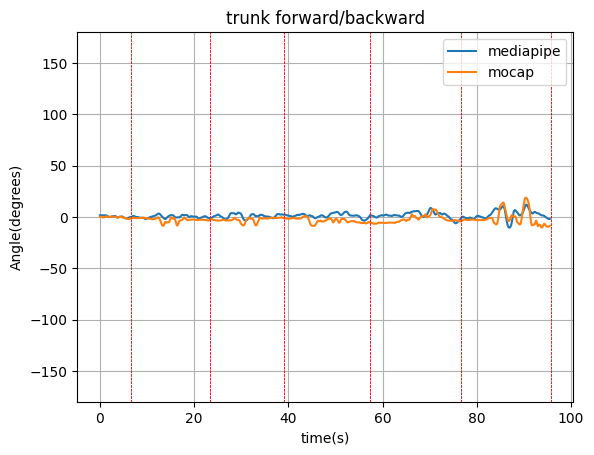

Correlation coefficient: 0.9206711807222346
Correlation coefficient:0.9207
RMSE of trunk left/right: 2.9833 
Max error :14.1201  epoch_time :84.98


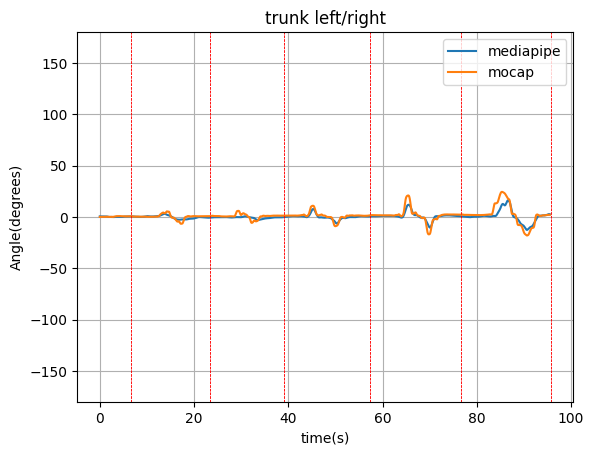

Correlation coefficient: 0.5109367055250537
Correlation coefficient:0.5109
RMSE of trunk rotation: 3.8699 
Max error :18.3821  epoch_time :86.87


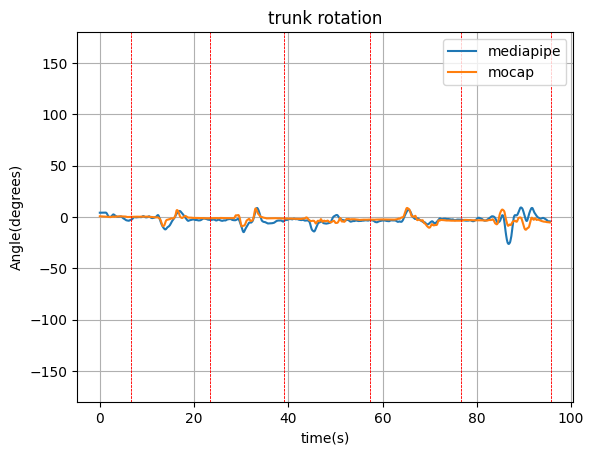

<Figure size 640x480 with 0 Axes>

In [11]:
# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRFB, mocapTRFB)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRFB,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk forward/backward')
rmse,me,me_i=errors(mocapTRFB,mpipeTRFB)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk forward/backward: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk forward backward.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRLR, mocapTRLR)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRLR,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRLR,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk left/right')
rmse,me,me_i=errors(mocapTRLR,mpipeTRLR)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk left/right: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk left right.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRRO, mocapTRRO)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRRO,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRRO,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk rotation')
rmse,me,me_i=errors(mocapTRRO,mpipeTRRO)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

Correlation coefficient: 0.6173274742911531
Correlation coefficient:0.6173
RMSE of right shoulder flexion/extension: 22.0729 
Max error :318.7015  epoch_time :65.45


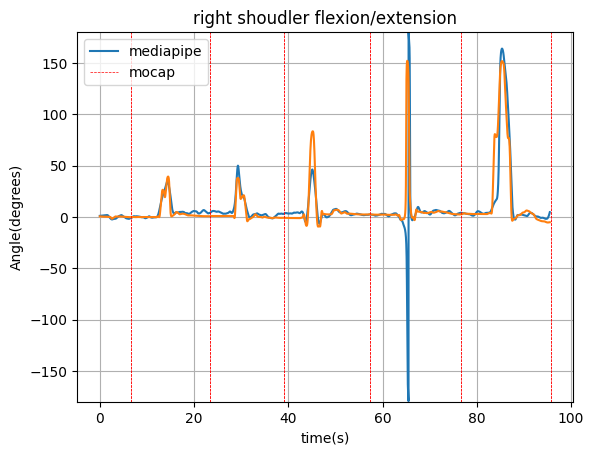

Correlation coefficient: 0.9344595475574012
Correlation coefficient:0.9345
RMSE of right shoulder abduction/adduction: 3.8810 
Max error :30.1704  epoch_time :66.03


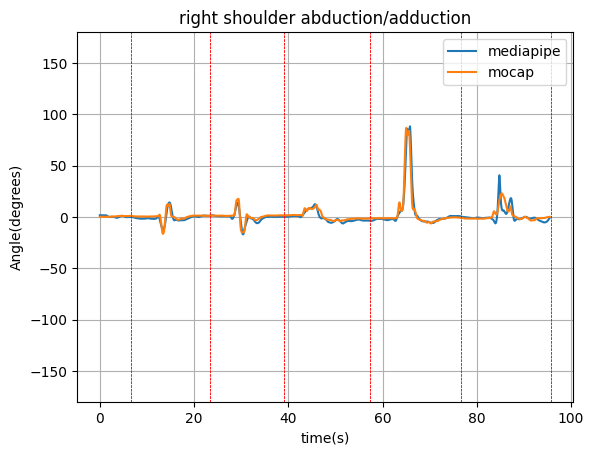

Correlation coefficient: 0.6800324562678348
Correlation coefficient:0.6800
RMSE of right shoulder internal/external rotation: 7.6127 
Max error :81.9822  epoch_time :78.33


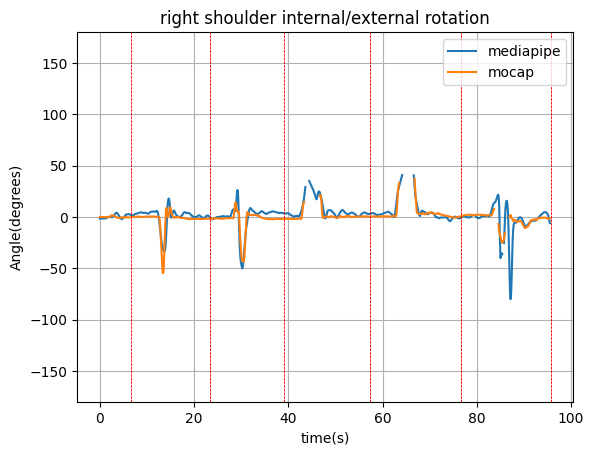

Correlation coefficient: 0.9027553511281159
Correlation coefficient:0.9028
RMSE of left shoulder flexion/extension: 10.4548 
Max error :66.7153  epoch_time :88.78


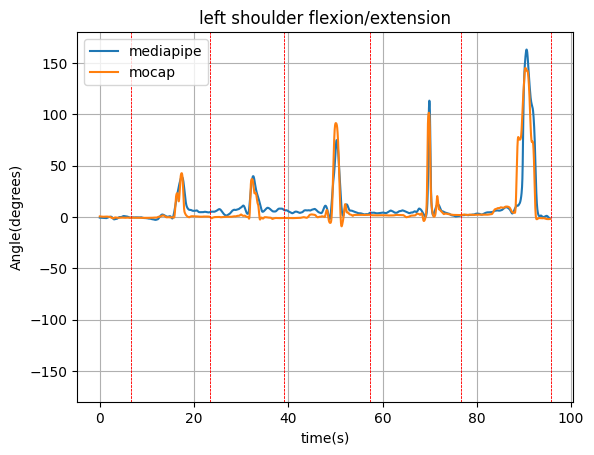

Correlation coefficient: 0.9068127614361736
Correlation coefficient:0.9068
RMSE of left shoulder abduction/adduction: 4.4542 
Max error :28.0184  epoch_time :89.81


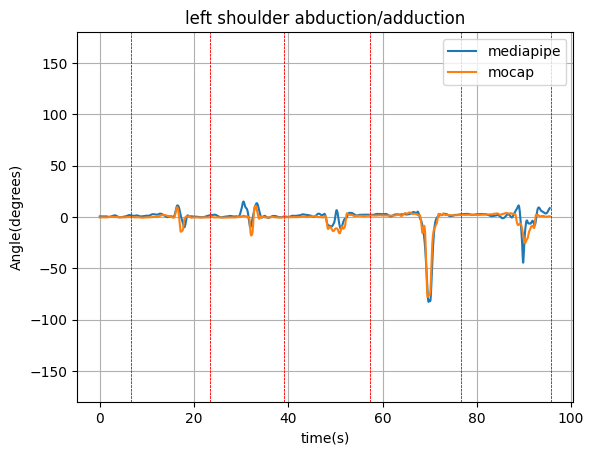

Correlation coefficient: 0.6800324562678348
Correlation coefficient:0.6800
RMSE of left shoulder internal/external rotation: 5.3799 
Max error :26.9914  epoch_time :16.92


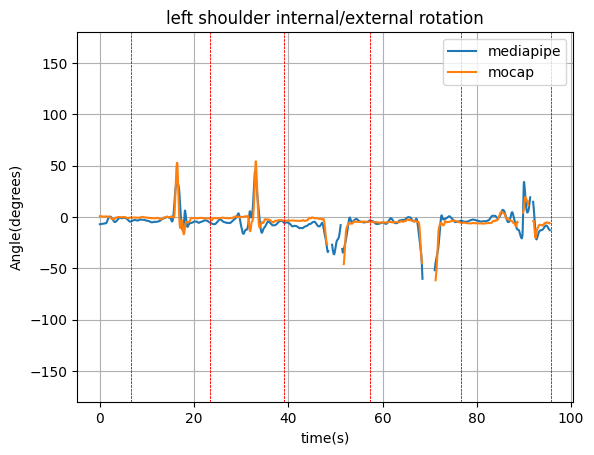

<Figure size 640x480 with 0 Axes>

In [12]:
# Plotting the shoulder angles

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSFE, mocapRSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSFE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')

rmse,me,me_i=errors(mocapRSFE,mpipeRSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoudler flexion extension.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSAA, mocapRSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSAA,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('right shoulder abduction/adduction')

rmse,me,me_i=errors(mocapRSAA,mpipeRSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoulder abduction adduction.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeRSIE1, mocapRSIE1 = np.array(mpipeRSIE), np.array(mocapRSIE)
mask = ~np.isnan(mpipeRSIE1) & ~np.isnan(mocapRSIE1) 
mpipeRSIE1 = mpipeRSIE1[mask]
mocapRSIE1 = mocapRSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSIE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('right shoulder internal/external rotation')

rmse,me,me_i = errors(mocapRSIE,mpipeRSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoulder internal external rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()


# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSFE, mocapLSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSFE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder flexion/extension')

rmse, me , me_i =errors(mocapLSFE,mpipeLSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder flexion extension.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSAA, mocapLSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSAA,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder abduction/adduction')

rmse,me,me_i=errors(mocapLSAA,mpipeLSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder abduction adduction.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeLSIE1, mocapLSIE1 = np.array(mpipeLSIE), np.array(mocapLSIE)
mask = ~np.isnan(mpipeLSIE1) & ~np.isnan(mocapLSIE1)
mpipeLSIE1 = mpipeLSIE1[mask]
mocapLSIE1 = mocapLSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSIE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder internal/external rotation')

rmse, me , me_i = errors(mocapLSIE,mpipeLSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder internal external rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()


In [13]:
# Showing data in a pptx
graph_dic={'Right Elbow Angle':[mocapRightElbowAngle,mpipeRightElbowAngle],'Left Elbow Angle':[mocapLeftElbowAngle,mpipeLeftElbowAngle],
           'Trunk forward/backward':[mocapTRFB,mpipeTRFB],'Trunk left/right':[mocapTRLR,mpipeTRLR], 'Trunk rotation':[mocapTRRO,mpipeTRRO],
           'Right shoulder flexion/extension':[mocapRSFE,mpipeRSFE],'Right shoulder abduction/adduction':[mocapRSAA,mpipeRSAA],'Right shoulder rotation':[mocapRSIE,mpipeRSIE],
            'Left shoulder flexion/extension':[mocapLSFE,mpipeLSFE],'Left shoulder abduction/adduction':[mocapLSAA,mpipeLSAA] ,'Left shoulder rotation':[mocapLSIE,mpipeLSIE]}
graph_names=list(graph_dic.keys())

# delete the previous graphs pptx if it exists
try:
    os.remove(pth+'\\graphs_'+id+'.pptx')
except:
    pass
# Save the graphs to the PowerPoint presentation
tot=0
error_list=[]
graph_no=0
for graph,error,name in zip(graphs,RMSEs,graph_names):
    save_graph_to_pptx(prs, graph, error)
    err=float(error.split(':')[2].split('\n')[0].strip())
    tot=tot+err
    error_list.append(err)
    
    if task_present:
        table_data=[]
        table_data.append(['task no:','RMSE','Max Error','correlation'])
        mocapList,mpipeList = split_list_by_indexes(graph_dic[name][0],task_index) , split_list_by_indexes(graph_dic[name][1],task_index)
        for i in range(task_no):
            if i == 0:
                continue
            mocapArray ,mpipeArray  = np.array(mocapList[i]) ,np.array(mpipeList[i])
            mask = ~np.isnan(mocapArray) & ~np.isnan(mpipeArray) 
            mocapArray = mocapArray[mask]
            mpipeArray = mpipeArray[mask]
            rmse,me,me_i=errors(mocapArray,mpipeArray)
            slope_mask = high_slope_index(mocapArray,window_length=50,slope_threshold=0.05)
            mocapArray = mocapArray[slope_mask]
            mpipeArray = mpipeArray[slope_mask]
            if len(mocapArray)>50:
                corr=pearsonr(mocapArray,mpipeArray)[0]
            else:
                print(name,i)
                corr=np.nan
            table_data.append([f"task{i}",f"{rmse:.4f}",f"{me:.4f}",f"{corr:.4f}"])
        prs=add_table_slide(prs,name,table_data)
        
    graph_no+=1
        
    
# Add a slide with a title and content layout
slide_layout = prs.slide_layouts[6]
slide = prs.slides.add_slide(slide_layout)

left = Inches(0.5)
top = Inches(1)
width = Inches(6)
height = Inches(4.5)

# Define the number of rows and columns for the table
num_rows = 12
num_cols = 3

# Define the width and height of the table
table_width = Inches(9.5)  # Adjust the value according to your desired width
table_height = Inches(3.5)  # Adjust the value according to your desired height

# Calculate the width and height of each cell in the table
cell_width = int(table_width / num_cols)
cell_height = int(table_height / num_rows)

# Add the table to the slide
left = top = Inches(0.25)  # Adjust the values to position the table on the slide
table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

# Set the column widths
for i in range(num_cols):
    table.columns[i].width = cell_width

# Set the row heights
for i in range(num_rows):
    table.rows[i].height = cell_height

# Populate the table with content
table.cell(0, 0).text = "Angle"
table.cell(0, 1).text = "RMSE"
table.cell(0, 2).text = "Correlation"

for i in range(1,12):
    table.cell(i,0).text = graph_names[i-1]
    table.cell(i,1).text = str(error_list[i-1])
    table.cell(i,2).text = str(f"{corr_list[i-1]:.4f}")

# Add the description as a text box
txBox = slide.shapes.add_textbox(left, top + height + Inches(1.5), width, Inches(1))
tf = txBox.text_frame
p = tf.add_paragraph()
p.text = 'Average RMSE: '+str(f'{tot/len(graphs):.4f}')

print('Average RMSE: '+str(tot/len(graphs)))

id = pth.split('\\')[-1].split('_')[-1]

# Save the presentation
prs.save(pth+'\\graphs_'+id+'.pptx')

Trunk rotation 3
Average RMSE: 8.505190909090912


In [14]:
s=[]
for i in df_mpipe.columns.tolist()[1:-2]:
    if '' in i:
        # Calculate the correlation coefficient and p-value
        correlation, p_value = pearsonr(df_mocap[i],df_mpipe[i])
        # Print the correlation coefficient and p-value
        print(i," Correlation coefficient:", correlation)
        s.append(correlation)
s=np.array(s)
print('mean',s.mean())

LS_x  Correlation coefficient: 0.9227609267215645
LS_y  Correlation coefficient: 0.8992785197190899
LS_z  Correlation coefficient: 0.7565669023822761
LE_x  Correlation coefficient: 0.7935677877912786
LE_y  Correlation coefficient: 0.8749174870586579
LE_z  Correlation coefficient: 0.7853103128915478
LW_x  Correlation coefficient: 0.9488604667390415
LW_y  Correlation coefficient: 0.9324292132819023
LW_z  Correlation coefficient: 0.8596534444054776
RS_x  Correlation coefficient: 0.8619708693388871
RS_y  Correlation coefficient: 0.8963014011045116
RS_z  Correlation coefficient: 0.6028865584572927
RE_x  Correlation coefficient: 0.7944518998592458
RE_y  Correlation coefficient: 0.8793191924769209
RE_z  Correlation coefficient: 0.7611426215567687
RW_x  Correlation coefficient: 0.9520197114341968
RW_y  Correlation coefficient: 0.9343523657966097
RW_z  Correlation coefficient: 0.8623263922767392
TR_x  Correlation coefficient: 0.936206467776539
TR_y  Correlation coefficient: 0.8853858031751384
m

In [15]:
df=pd.DataFrame()
df['epoch_time']=df_mocap['epoch_time']
df['moRtEl']=pd.Series(mocapRightElbowAngle)
df['moLtEl']=pd.Series(mocapLeftElbowAngle)
df['moTrFB']=pd.Series(mocapTRFB)
df['moTrLR']=pd.Series(mocapTRLR)
df['moTrRO']=pd.Series(mocapTRRO)
df['moRSFE']=pd.Series(mocapRSFE)
df['moRSAA']=pd.Series(mocapRSAA)
df['moRSIE']=pd.Series(mocapRSIE)
df['moLSFE']=pd.Series(mocapLSFE)
df['moLSAA']=pd.Series(mocapLSAA)
df['moLSIE']=pd.Series(mocapLSIE)

df['mpRtEl']=pd.Series(mpipeRightElbowAngle)
df['mpLtEl']=pd.Series(mpipeLeftElbowAngle)
df['mpTrFB']=pd.Series(mpipeTRFB)
df['mpTrLR']=pd.Series(mpipeTRLR)
df['mpTrRO']=pd.Series(mpipeTRRO)
df['mpRSFE']=pd.Series(mpipeRSFE)
df['mpRSAA']=pd.Series(mpipeRSAA)
df['mpRSIE']=pd.Series(mpipeRSIE)
df['mpLSFE']=pd.Series(mpipeLSFE)
df['mpLSAA']=pd.Series(mpipeLSAA)
df['mpLSIE']=pd.Series(mpipeLSIE)

df.to_csv(pth+'\\angles.csv',index=False)

In [16]:
x=np.array([1,1,np.nan])
y=np.array([1,1,1])


print(errors(x,y))

(0.0, 0.0, 0)
